In [8]:
import pandas as pd
import numpy as np
import snowflake.connector

#  Connect to Snowflake
conn = snowflake.connector.connect(
    account="Q2-Q2EDW",
    user="THEBNER",
    role="DW_IMPL_USRS",
    warehouse="Q2_WH_BI",
    database="Q2_ODS",
    schema="MAVENLINK",
    authenticator="externalbrowser",
)

# Run SQL and export to Excel
cur = conn.cursor()
try:
    sql = """
WITH
/* ---------- Mavenlink workspaces ---------- */
ml_workspace AS (
  SELECT
      w.ID::STRING                                AS workspace_id,
      NULLIF(TRIM(w.CUSTOM_WORK_ORDER_ID), '')    AS custom_work_order_id,
      NULLIF(TRIM(w.CUSTOM_WORK_ORDER), '')       AS custom_work_order,
      NULLIF(TRIM(w.CUSTOM_PROJECT_SUB_TYPE), '') AS custom_project_sub_type
  FROM Q2_ODS.MAVENLINK.WORKSPACE w
),

/* ---------- Map workspace -> Salesforce WO (ID first, fallback name), de-dup ---------- */
ws_map_id AS (
  SELECT ms.workspace_id, wo.ID::STRING AS wo_id, wo.NAME AS wo_code, 1 AS prio
  FROM ml_workspace ms
  JOIN Q2_ODS.SALESFORCE.WORK_ORDER_C wo
    ON UPPER(TRIM(wo.ID::STRING)) = UPPER(TRIM(ms.custom_work_order_id))
),
ws_map_name AS (
  SELECT ms.workspace_id, wo.ID::STRING AS wo_id, wo.NAME AS wo_code, 2 AS prio
  FROM ml_workspace ms
  JOIN Q2_ODS.SALESFORCE.WORK_ORDER_C wo
    ON ms.custom_work_order_id IS NULL
   AND UPPER(TRIM(wo.NAME)) = UPPER(TRIM(ms.custom_work_order))
),
ws_to_wo AS (
  SELECT workspace_id, wo_id, wo_code
  FROM (
    SELECT m.*,
           ROW_NUMBER() OVER (PARTITION BY m.workspace_id ORDER BY m.prio) AS rn
    FROM (SELECT * FROM ws_map_id UNION ALL SELECT * FROM ws_map_name) m
  ) x
  WHERE rn = 1
),

/* ---------- Mavenlink: aggregate once per workspace×user (COALESCE user_id -> -1) ---------- */
time_by_ws_user AS (
  SELECT
      te.WORKSPACE_ID::STRING AS workspace_id,
      COALESCE(te.USER_ID, -1) AS user_id_num,
      (SUM(COALESCE(te.TIME_IN_MINUTES,0)) / 60.0)::NUMBER(18,2) AS hours_logged
  FROM Q2_ODS.MAVENLINK.TIME_ENTRY te
  WHERE te.approved = TRUE
    AND te._fivetran_deleted = FALSE
  GROUP BY te.WORKSPACE_ID, COALESCE(te.USER_ID, -1)
),
alloc_by_ws_user AS (
  SELECT
      wr.WORKSPACE_ID::STRING AS workspace_id,
      COALESCE(wr.USER_ID, -1) AS user_id_num,
      (SUM(COALESCE(wa.MINUTES,0)) / 60.0)::NUMBER(18,2) AS allocated_hours
  FROM Q2_ODS.MAVENLINK.WORKSPACE_RESOURCE wr
  LEFT JOIN Q2_ODS.MAVENLINK.WORKSPACE_ALLOCATION wa
    ON wa.WORKSPACE_RESOURCE_ID = wr.ID
  WHERE wa._FIVETRAN_DELETED = FALSE
  GROUP BY wr.WORKSPACE_ID, COALESCE(wr.USER_ID, -1)
),
users_in_ws AS (
  SELECT workspace_id, user_id_num FROM alloc_by_ws_user
  UNION
  SELECT workspace_id, user_id_num FROM time_by_ws_user
),
ml_user_hours AS (
  SELECT
      u.workspace_id,
      map.wo_id,
      map.wo_code,
      u.user_id_num,
      COALESCE(a.allocated_hours, 0)::NUMBER(18,2) AS allocated_hours,
      COALESCE(t.hours_logged,    0)::NUMBER(18,2) AS hours_logged
  FROM users_in_ws u
  JOIN ws_to_wo map ON map.workspace_id = u.workspace_id
  LEFT JOIN alloc_by_ws_user a
    ON a.workspace_id = u.workspace_id AND a.user_id_num = u.user_id_num
  LEFT JOIN time_by_ws_user t
    ON t.workspace_id = u.workspace_id AND t.user_id_num = u.user_id_num
),

/* ---------- Latest Role per workspace×user ---------- */
wr_latest AS (
  SELECT
      wr.WORKSPACE_ID::STRING AS workspace_id,
      wr.USER_ID              AS user_id_num,
      COALESCE(wr.ROLE_NAME,'Unassigned') AS role_name
  FROM Q2_ODS.MAVENLINK.WORKSPACE_RESOURCE wr
  QUALIFY ROW_NUMBER() OVER (
    PARTITION BY wr.WORKSPACE_ID, wr.USER_ID
    ORDER BY wr.UPDATED_AT DESC, wr.ID DESC
  ) = 1
),

/* ---------- WOLI lists per WO (IDs, Names, Count) ---------- */
woli_lists_by_wo AS (
  SELECT
    woli.WORK_ORDER_C::STRING AS wo_id,
    COUNT(DISTINCT woli.ID)   AS woli_count,
    LISTAGG(DISTINCT woli.ID::STRING, ', ')   AS woli_ids,
    LISTAGG(DISTINCT woli.NAME, ', ')         AS woli_names
  FROM Q2_ODS.SALESFORCE.WORK_ORDER_LINE_ITEM_C woli
  GROUP BY woli.WORK_ORDER_C
),

/* ---------- Distinct Product names per WO ---------- */
products_by_wo AS (
  SELECT
    woli.WORK_ORDER_C::STRING AS wo_id,
    LISTAGG(DISTINCT p2.NAME, ', ') WITHIN GROUP (ORDER BY p2.NAME) AS product_names
  FROM Q2_ODS.SALESFORCE.WORK_ORDER_LINE_ITEM_C woli
  LEFT JOIN Q2_ODS.SALESFORCE.PRODUCT_2 p2 ON p2.ID = woli.PRODUCT_C
  GROUP BY woli.WORK_ORDER_C
),

/* ---------- Salesforce WO header + Contingent WO linkage + Record Type ---------- */
wo_base AS (
  SELECT
    wo.ID::STRING             AS wo_id,
    wo.NAME                   AS wo_code,
    wo.ACCOUNT_C              AS account_id,
    wo.OPPORTUNITY_C::STRING  AS opportunity_id,
    wo.DESCRIPTION_C          AS work_order_description,
    wo.STATUS_C               AS project_status_sf,
    wo.PROJECT_START_DATE_C   AS slotted_start_date,
    wo.REVISED_GO_LIVE_DATE_C AS slotted_go_live_date,
    wo.DELIVERY_TEAM_C        AS delivery_team,
    wo.ANALYSIS_OUTLIER_REASON_C AS analysis_outlier_reason,

    CAST(wo.PM_HOURS_BUDGETED_C               AS NUMBER(18,2)) AS pm_hours_forecast,
    CAST(wo.BC_HOURS_BUDGETED_C               AS NUMBER(18,2)) AS bc_hours_forecast,
    CAST(wo.CS_HOURS_BUDGETED_C               AS NUMBER(18,2)) AS cs_hours_forecast,
    CAST(wo.DATA_SERVICES_IE_HOURS_FORECAST_C AS NUMBER(18,2)) AS data_services_forecast,

    wo.PROJECT_MANAGER_C                  AS pm_user_id,
    wo.BUSINESS_CONSULTANT_C              AS bc_user_id,
    wo.CONFIGURATION_SPECIALIST_C         AS cs_user_id,

    /* keep as date/time per your preference */
    wo.CREATED_DATE                       AS wo_created_date,

    /* Contingent / Platform WO linkage */
wo.PLATFORM_WO_FOR_RFA_C AS platform_wo_for_rfa_id,

CASE
  WHEN wo.PLATFORM_WO_FOR_RFA_C IS NULL
       OR TRIM(wo.PLATFORM_WO_FOR_RFA_C) = ''
  THEN NULL
  ELSE pwo.NAME
END AS contingent_wo_code,

/* Contingent start date (from contingent WO) */
CASE
  WHEN wo.PLATFORM_WO_FOR_RFA_C IS NULL
       OR TRIM(wo.PLATFORM_WO_FOR_RFA_C) = ''
  THEN NULL
  ELSE pwo.PROJECT_START_DATE_C
END AS contingent_wo_start_date,

/* Contingent go-live:
   1. If contingent WO has REVISED_GO_LIVE_DATE_C, use it.
   2. Else fallback to later of (today + 6 months) OR (contingent start + 6 months).
*/
CASE
  WHEN wo.PLATFORM_WO_FOR_RFA_C IS NULL
       OR TRIM(wo.PLATFORM_WO_FOR_RFA_C) = ''
  THEN NULL

  WHEN pwo.REVISED_GO_LIVE_DATE_C IS NOT NULL
  THEN pwo.REVISED_GO_LIVE_DATE_C

  ELSE GREATEST(
         DATEADD(month, 6, CURRENT_DATE),
         DATEADD(month, 6, COALESCE(pwo.PROJECT_START_DATE_C, CURRENT_DATE))
       )
END AS contingent_wo_go_live_date,

    /* Record Type Id forced to text + inline mapping to name */
    o.RECORD_TYPE_ID::STRING              AS opportunity_record_type_id,
    CASE o.RECORD_TYPE_ID
      WHEN '0120h000000kwUeAAI' THEN 'Q2 Gro Cross Sales Opportunity'
      WHEN '0121A000000GVD3QAO' THEN 'Helix Cross Sale Opportunity'
      WHEN '0121A000000MazmQAC' THEN 'Helix Net New Opportunity'
      WHEN '0121A000000UlN6QAK' THEN 'Centrix Cross Sales Opportunity Record Type'
      WHEN '0124X000000AZVYQA4' THEN 'Q2 Off-Platform Sales Opportunity Cross Sales'
      WHEN '0124X000001yTi5QAE' THEN 'Channel Partner Opportunity'
      WHEN '0124X000001ZWN2QAO' THEN 'PL Cross Sales Opportunity'
      WHEN '012800000003bw0AAA' THEN 'Q2 Net New Sales Opportunity'
      WHEN '012800000003Z3RAAU' THEN 'Q2 Cross Sales Opportunity Record Type'
      WHEN '012C0000000Q4NyIAK' THEN 'Renewal/Extension Opportunity Record Type'
      WHEN '012C0000000Q9x0IAC' THEN 'Amendment'
      WHEN '012C0000000QFAxIAO' THEN 'Termination Record Type'
      ELSE 'Unknown Record Type'
    END AS opportunity_record_type_name

  FROM Q2_ODS.SALESFORCE.WORK_ORDER_C wo
  LEFT JOIN Q2_ODS.SALESFORCE.OPPORTUNITY o
    ON o.ID = wo.OPPORTUNITY_C
  LEFT JOIN Q2_ODS.SALESFORCE.WORK_ORDER_C pwo
    ON pwo.NAME = wo.PLATFORM_WO_FOR_RFA_C
),

sf_account AS (
  SELECT a.ID::STRING AS account_id,
         a.NAME       AS account_name,
         a.ACCOUNT_NUMBER AS account_number
  FROM Q2_ODS.SALESFORCE.ACCOUNT a
),
sf_user AS (
  SELECT u.ID::STRING AS user_id,
         u.NAME       AS user_name
  FROM Q2_ODS.SALESFORCE.USER u
),
workspace_attrs_by_wo AS (
  SELECT
    map.wo_id,
    MAX(ms.custom_project_sub_type) AS project_sub_type
  FROM ml_workspace ms
  JOIN ws_to_wo map ON map.workspace_id = ms.workspace_id
  GROUP BY map.wo_id
)

SELECT
  /* Keys */
  wb.wo_id                                  AS "Work Order ID",
  wb.wo_code                                AS "Work Order Code",

  /* Salesforce header */
  acc.account_name                           AS "Account Name",
  acc.account_number                         AS "Account Number",
  wb.work_order_description                  AS "Work Order Description",
  wb.project_status_sf                       AS "Project Status",
  wb.slotted_start_date                      AS "Slotted Start Date",
  wb.slotted_go_live_date                    AS "Slotted Go-Live Date",
  wa.project_sub_type                        AS "Project Sub-Type",
  wb.contingent_wo_code                      AS "Contingent Work Order",
  wb.contingent_wo_go_live_date              AS "Contingent Go-Live Date",
  wb.analysis_outlier_reason                 AS "Analysis Outlier Reason",
  wb.delivery_team                           AS "Delivery Team",

  /* NEW surfaced fields */
  wb.wo_created_date                         AS "Work Order Created Date",
  wb.opportunity_id                          AS "Opportunity Id",
  wb.opportunity_record_type_id              AS "Opportunity Record Type Id",
  wb.opportunity_record_type_name            AS "Opportunity Record Type",

  /* People */
  pm.user_name                               AS "Project Manager (SF)",
  bc_user.user_name                          AS "BC (SF)",
  cs_user.user_name                          AS "Configuration Specialist (SF)",

  /* Products & WOLIs */
  pr.product_names                           AS "Product Name(s)",
  wl.woli_ids                                AS "Work Order Line Item Ids",
  wl.woli_names                              AS "Work Order Line Item Names",
  wl.woli_count                              AS "WOLI Count",

  /* Forecasts (normalized) */
  wb.pm_hours_forecast                       AS "PM Hours Forecast",
  wb.bc_hours_forecast                       AS "BC Hours Forecast",
  wb.cs_hours_forecast                       AS "IE Hours Forecast (Configuration Specialist)",
  wb.data_services_forecast                  AS "Data Services Forecast",

  /* Mavenlink per-user metrics + Role + ML user name */
  CASE
    WHEN ml.user_id_num = -1          THEN 'Unnamed Resource'
    WHEN ml.user_id_num IS NULL       THEN '—'
    ELSE mu.FULL_NAME
  END                                      AS "Mavenlink User Name",
  CASE
    WHEN ml.user_id_num = -1          THEN 'Unnamed Resource'
    WHEN ml.user_id_num IS NULL       THEN '—'
    ELSE mu.FULL_NAME
  END                                      AS "User Name",
  ml.user_id_num                           AS "Mavenlink User Id",
  CASE
    WHEN ml.user_id_num = -1          THEN 'Unnamed'
    WHEN ml.user_id_num IS NULL       THEN 'No ML Resource'
    ELSE COALESCE(wr.role_name,'Unassigned')
  END                                      AS "Role Name",
  COALESCE(ml.allocated_hours, 0)          AS "Allocated Hours (User×CWO)",
  COALESCE(ml.hours_logged,   0)           AS "Hours Logged (User×CWO)"

FROM wo_base wb
LEFT JOIN ml_user_hours ml           ON ml.wo_id       = wb.wo_id
LEFT JOIN sf_account acc             ON acc.account_id = wb.account_id
LEFT JOIN workspace_attrs_by_wo wa   ON wa.wo_id       = wb.wo_id
LEFT JOIN products_by_wo pr          ON pr.wo_id       = wb.wo_id
LEFT JOIN woli_lists_by_wo wl        ON wl.wo_id       = wb.wo_id

/* People lookups (SF) */
LEFT JOIN sf_user pm                 ON pm.user_id      = wb.pm_user_id
LEFT JOIN sf_user bc_user            ON bc_user.user_id = wb.bc_user_id
LEFT JOIN sf_user cs_user            ON cs_user.user_id = wb.cs_user_id

/* Mavenlink role + user name */
LEFT JOIN wr_latest wr               ON wr.workspace_id = ml.workspace_id
                                     AND wr.user_id_num = ml.user_id_num
LEFT JOIN Q2_ODS.MAVENLINK.USER mu   ON mu.ID           = ml.user_id_num

-- Optional filter you had before:
-- WHERE "Work Order Code" = 'WO-963371'

ORDER BY "Account Name", "Work Order Code", "Mavenlink User Name"
    """

    cur.execute(sql)

    # Fetch all results into a pandas DataFrame
    df = cur.fetch_pandas_all()
    # Save DataFrame to Excel
    #output_path = r"C:\Users\thebner\OneDrive - Q2e\ProjEchoHrs.xlsx"
    #df.to_excel(output_path, index=False)

    print(f"✅ Projects from Snowflake successfully pulled.")

finally:
    cur.close()
    conn.close()
## Query for totals
dtquery = '`Delivery Team` in ["CD - Wedge","CD - Product SDK"]'
statusquery = '`Project Status` not in ["Cancelled", "Completed", "Customer Requested Cancellation", "In Question"]'
subtypequery = '`Project Sub-Type` == "PROSERV"'
## can use below for testing specific WOs, just include in the query
## woquery = '`Work Order Code` == "WO-726971"'

allWOs = (
    df
    .query(f"{dtquery} and {statusquery} and {subtypequery}")
    .reset_index(drop=True)
)
## below resets names to make them more friendly
allWOs = allWOs.rename(columns={
    "Allocated Hours (User×CWO)": "Allocated_Hours",
    "Hours Logged (User×CWO)": "Hours_Logged"
}).reset_index()
## Query for Tailwinds Specific
dtTWquery = '`Delivery Team` in ["CD - Wedge"]'
## can use below for testing specific WOs, just include in the query
## woquery = '`Work Order Code` == "WO-726971"'
allTWWOs = (
    df
    .query(f"{dtTWquery} and {statusquery} and {subtypequery}")
    .reset_index(drop=True)
)
## below resets names to make them more friendly
allTWWOs = allTWWOs.rename(columns={
    "Allocated Hours (User×CWO)": "Allocated_Hours",
    "Hours Logged (User×CWO)": "Hours_Logged"
}).reset_index()
## Query for Non-Actionable Non-Certified
NANC_dtquery = '`Delivery Team` in ["CD - Product SDK"]'
NANC_statusquery = '`Project Status` in ["Pending GA"]'
allNANCWOs = (
    df
    .query(f"{NANC_dtquery} and {NANC_statusquery} and {subtypequery}")
    .reset_index(drop=True)
)
## below resets names to make them more friendly
allNANCWOs = allNANCWOs.rename(columns={
    "Allocated Hours (User×CWO)": "Allocated_Hours",
    "Hours Logged (User×CWO)": "Hours_Logged"
}).reset_index()
## This section handles the shift of work from ineligible to eligible

import numpy as np
import pandas as pd

# allWOs already exists and includes all PROSERV work, with renamed hour columns
# We aggregate to WO-level backlog
wo_backlog = (
    allWOs
    .groupby("Work Order Code", as_index=False)
    .agg({
        "Allocated_Hours": "sum",
        "Hours_Logged": "sum",
        "Delivery Team": "first",
        "Account Name": "first",
        "Work Order Description": "first",
        "Contingent Work Order": "first",
        "Contingent Go-Live Date": "first",     # <-- NEW: use contingent go-live from SQL
        "Slotted Go-Live Date": "first"         # still available if needed elsewhere
    })
)
wo_backlog = wo_backlog.query("`Contingent Work Order`.notnull()")

wo_backlog["Backlog"] = wo_backlog["Allocated_Hours"] - wo_backlog["Hours_Logged"]

# Normalize dates, coercing bad values to NaT instead of error
wo_backlog["Contingent Go-Live Date"] = pd.to_datetime(
    wo_backlog["Contingent Go-Live Date"], errors="coerce"
)

# Treat Tailwind as Delivery Team == "CD - Wedge" (adjust if needed)
is_tailwind = wo_backlog["Delivery Team"].eq("CD - Wedge")

# Start-of-model date (Month 0)
today = pd.Timestamp.today().normalize()

# WOs that are Q2 today (not Tailwind)
q2_wo = wo_backlog[~is_tailwind].copy()

# Eligible WOs:
#   - Have a Contingent Work Order populated
#   - Have a valid Contingent Go-Live Date
eligible = q2_wo[
    q2_wo["Contingent Work Order"].notna()
    & q2_wo["Contingent Go-Live Date"].notna()
].copy()

# Compute days/months from today until contingent go-live
eligible["Days_To_GoLive"] = (eligible["Contingent Go-Live Date"] - today).dt.days

# Anything in the past goes to Month 0; convert to integer months safely
eligible["Months_To_GoLive"] = (
    (eligible["Days_To_GoLive"] // 30)
    .clip(lower=0)
    .astype(int)
)

# This is the amount of backlog that will become TW-eligible at that month
shift_schedule = (
    eligible
    .groupby("Months_To_GoLive", as_index=False)["Backlog"]
    .sum()
    .rename(columns={
        "Months_To_GoLive": "Month",
        "Backlog": "Shift_Hours"
    })
)

# Turn into a simple dict: month_index -> hours shifted from Q2 to Tailwind
tw_shift_map = {
    int(row["Month"]): float(row["Shift_Hours"])
    for _, row in shift_schedule.iterrows()
}

# ----------------------------------------------
# OUTPUT A — Summary table of monthly work shift
# ----------------------------------------------

print("\n===== MONTHLY SHIFT SUMMARY: Q2 → Tailwind =====")
if len(shift_schedule) == 0:
    print("No work detected that becomes Tailwind-eligible.")
else:
    print(shift_schedule.to_string(index=False))

# ------------------------------------------------
# OUTPUT B — Detailed work shifting by WO (optional)
# ------------------------------------------------
detailed_shift = eligible[[
    "Work Order Code",
    "Account Name",
    "Work Order Description",
    "Backlog",
    "Contingent Work Order",
    "Contingent Go-Live Date",
    "Months_To_GoLive"
]].sort_values(["Months_To_GoLive", "Contingent Go-Live Date"])

detailed_shift = eligible[[
    "Work Order Code",
    "Backlog",
    "Contingent Work Order",
    "Contingent Go-Live Date",
    "Months_To_GoLive"
]].sort_values(["Months_To_GoLive", "Contingent Go-Live Date"])

print("\n===== DETAILED WORK SHIFTING (By Work Order) =====")
if len(detailed_shift) == 0:
    print("No individual WOs found that shift work to Tailwind.")
else:
    print(detailed_shift.to_string(index=False))

## Version with Tailwind work becoming eligible

# ---------------------------
# BASE BACKLOG LEVELS
# ---------------------------
TW_backlog = float(total_TW_backlog)
Q2_backlog = float(total_backlog - total_TW_backlog)

# Capacity assumptions
TW_capacity = 6 * 135.2   # 811.2
Q2_capacity = 2 * 135.2   # 270.4
total_capacity = TW_capacity + Q2_capacity

# Incoming work per month: 1 quarter total, 0% TW, 100% Q2
TW_incoming = 1440 * 0 * (1/3)
Q2_incoming = 1440 * 1 * (1/3)

months = 28

results_full = []
results_reduced = []
"""
# ---------------------------
# MODEL 1 – FULL TEAM 28 MONTHS (WITH Q2→TW SHIFT)
# ---------------------------
TW_b = TW_backlog
Q2_b = Q2_backlog

for month in range(1, months + 1):
    month_idx = month - 1  # Month 0 is "today"

    # Normal burn
    TW_burn = min(TW_b, TW_capacity)
    Q2_burn = min(Q2_b, Q2_capacity)

    TW_b = max(TW_b - TW_burn + TW_incoming, 0)
    Q2_b = max(Q2_b - Q2_burn + Q2_incoming, 0)

    # Apply Q2 -> Tailwind eligibility shift for this month
    shift = tw_shift_map.get(month_idx, 0.0)
    if shift > 0:
        actual_shift = min(Q2_b, shift)
        Q2_b -= actual_shift
        TW_b += actual_shift

    total_b = TW_b + Q2_b
    total_cap_current = TW_capacity + Q2_capacity
    backlog_months = total_b / total_cap_current if total_cap_current > 0 else None

    results_full.append({
        "Month": month,
        "TW_Backlog": TW_b,
        "Q2_Backlog": Q2_b,
        "Total_Backlog": total_b,
        "Total_Capacity": total_cap_current,
        "Backlog_Months": backlog_months
    })

df_full = pd.DataFrame(results_full)
"""
# ---------------------------
# MODEL 2 – TAILWIND REMOVED WHEN BACKLOG MONTHS <= 4 (WITH Q2→TW SHIFT)
# ---------------------------
TW_b = TW_backlog
Q2_b = Q2_backlog

tailwind_active = True
results_reduced = []

for month in range(1, months + 1):
    month_idx = month - 1

    # Capacity & incoming depend on Tailwind being active or not
    if tailwind_active:
        TW_cap_current = TW_capacity
        TW_incoming_current = TW_incoming
        Q2_cap_current = Q2_capacity
        Q2_incoming_current = Q2_incoming
    else:
        TW_cap_current = 0
        TW_incoming_current = 0
        Q2_cap_current = Q2_capacity
        Q2_incoming_current = 0  # no new Q2 incoming after threshold

    # Burn
    TW_burn = min(TW_b, TW_cap_current)
    Q2_burn = min(Q2_b, Q2_cap_current)

    TW_b = max(TW_b - TW_burn + TW_incoming_current, 0)
    Q2_b = max(Q2_b - Q2_burn + Q2_incoming_current, 0)

    # Apply Q2 -> Tailwind eligibility shift for this month (only while Tailwind is active)
    if tailwind_active:
        shift = tw_shift_map.get(month_idx, 0.0)
        if shift > 0:
            actual_shift = min(Q2_b, shift)
            Q2_b -= actual_shift
            TW_b += actual_shift

    # Compute metrics
    total_b = TW_b + Q2_b
    total_cap_current = TW_cap_current + Q2_cap_current
    backlog_months = total_b / total_cap_current if total_cap_current > 0 else None

    # Trigger Tailwind removal when backlog months <= 4
    if tailwind_active and (backlog_months is not None) and (backlog_months <= 4):
        tailwind_active = False
        # At threshold, zero out Tailwind backlog
        TW_b = 0.0
        total_b = TW_b + Q2_b
        total_cap_current = Q2_capacity
        backlog_months = total_b / total_cap_current if total_cap_current > 0 else None

    results_reduced.append({
        "Month": month,
        "TW_Backlog": TW_b,
        "Q2_Backlog": Q2_b,
        "Total_Backlog": total_b,
        "Total_Capacity": total_cap_current,
        "Backlog_Months": backlog_months,
        "Tailwind_Active": tailwind_active
    })

df_reduced = pd.DataFrame(results_reduced)

##print("==== BURNDOWN MODEL – FULL TEAM ====")
##print(df_full)

print("\n==== BURNDOWN MODEL – TAILWIND REMOVED WHEN BACKLOG MONTHS <= 4 ====")
print(df_reduced)
### CHARTS with shift

import matplotlib.pyplot as plt

# Global style tweaks for "prettier" charts
plt.style.use("ggplot")

def add_labels(x, y, step=3, fmt="{:,.0f}"):
    """
    Add data labels to every `step`-th point.
    """
    for i, (xx, yy) in enumerate(zip(x, y)):
        if i % step == 0:
            plt.text(xx, yy, fmt.format(yy), fontsize=8, ha='center', va='bottom')
"""
# --------------------------------------
# 1) Backlog burndown – Model 1 (Full Team)
# --------------------------------------
plt.figure(figsize=(10, 6))
plt.plot(df_full["Month"], df_full["Total_Backlog"], marker='o', label="Total Backlog")
plt.plot(df_full["Month"], df_full["TW_Backlog"], marker='o', label="Tailwind Backlog")
plt.plot(df_full["Month"], df_full["Q2_Backlog"], marker='o', label="Q2 Backlog")

add_labels(df_full["Month"], df_full["Total_Backlog"], step=3)
add_labels(df_full["Month"], df_full["TW_Backlog"], step=3)
add_labels(df_full["Month"], df_full["Q2_Backlog"], step=3)

plt.xlabel("Month")
plt.ylabel("Backlog (Hours)")
plt.title("Model 1: Full Team – Backlog Burndown")
plt.legend()
plt.grid(True)
plt.tight_layout()
"""
# --------------------------------------
# 2) Backlog burndown – Model 2 (Tailwind Removed at 4-Month Threshold)
# --------------------------------------
plt.figure(figsize=(10, 6))
plt.plot(df_reduced["Month"], df_reduced["Total_Backlog"], marker='o', label="Total Backlog")
plt.plot(df_reduced["Month"], df_reduced["TW_Backlog"], marker='o', label="Tailwind Backlog")
plt.plot(df_reduced["Month"], df_reduced["Q2_Backlog"], marker='o', label="Q2 Backlog")

add_labels(df_reduced["Month"], df_reduced["Total_Backlog"], step=3)
add_labels(df_reduced["Month"], df_reduced["TW_Backlog"], step=3)
add_labels(df_reduced["Month"], df_reduced["Q2_Backlog"], step=3)

plt.xlabel("Month")
plt.ylabel("Backlog (Hours)")
plt.title("Model 2: Tailwind Removed – Backlog Burndown")
plt.legend()
plt.grid(True)
plt.tight_layout()
"""
# --------------------------------------
# 3) Side-by-side comparison of total backlog for both models
# --------------------------------------
plt.figure(figsize=(10, 6))
plt.plot(df_full["Month"], df_full["Total_Backlog"], marker='o', label="Model 1 – Full Team")
plt.plot(df_reduced["Month"], df_reduced["Total_Backlog"], marker='o', label="Model 2 – Tailwind Removed")

add_labels(df_full["Month"], df_full["Total_Backlog"], step=3)
add_labels(df_reduced["Month"], df_reduced["Total_Backlog"], step=3)

plt.xlabel("Month")
plt.ylabel("Backlog (Hours)")
plt.title("Total Backlog – Full Team vs Tailwind Removed")
plt.legend()
plt.grid(True)
plt.tight_layout()
"""
# --------------------------------------
# 4) Breakdown – Q2 vs Tailwind (Model 2, Hours)
# --------------------------------------
plt.figure(figsize=(10, 6))
plt.plot(df_reduced["Month"], df_reduced["TW_Backlog"], marker='o', label="Tailwind Backlog")
plt.plot(df_reduced["Month"], df_reduced["Q2_Backlog"], marker='o', label="Q2 Backlog")

add_labels(df_reduced["Month"], df_reduced["TW_Backlog"], step=3)
add_labels(df_reduced["Month"], df_reduced["Q2_Backlog"], step=3)

plt.xlabel("Month")
plt.ylabel("Backlog (Hours)")
plt.title("Model 2: Q2 vs Tailwind Backlog Over Time")
plt.legend()
plt.grid(True)
plt.tight_layout()
"""
# --------------------------------------
# 5) Backlog Months – Model 1
# --------------------------------------
plt.figure(figsize=(10, 6))
plt.plot(df_full["Month"], df_full["Backlog_Months"], marker='o', label="Backlog (Months)")

add_labels(df_full["Month"], df_full["Backlog_Months"], step=3, fmt="{:.1f}")

plt.xlabel("Month")
plt.ylabel("Backlog (Months)")
plt.title("Model 1: Full Team – Backlog in Months")
plt.legend()
plt.grid(True)
plt.tight_layout()
"""
# --------------------------------------
# 6) Backlog Months – Model 2
# --------------------------------------
plt.figure(figsize=(10, 6))
plt.plot(df_reduced["Month"], df_reduced["Backlog_Months"], marker='o', label="Backlog (Months)")

add_labels(df_reduced["Month"], df_reduced["Backlog_Months"], step=3, fmt="{:.1f}")

plt.xlabel("Month")
plt.ylabel("Backlog (Months)")
plt.title("Model 2: Tailwind Removed – Backlog in Months")
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.show()

Initiating login request with your identity provider. A browser window should have opened for you to complete the login. If you can't see it, check existing browser windows, or your OS settings. Press CTRL+C to abort and try again...
Going to open: https://q2.okta.com/app/snowflake/exkh22hcx4v1E1xvN1t7/sso/saml?SAMLRequest=jZJbc9owEIX%2Fikd9tiW7QIgGyDihTGhTSsH0kjdhC1CRJVsrX%2FLvK0xo04dk%2BqaRztn9VmdHN20uvZobEFqNURgQ5HGV6kyo%2FRhtkpk%2FRB5YpjImteJj9MQB3UxGwHJZ0LiyB7XiZcXBeq6QAto9jFFlFNUMBFDFcg7UpnQdf36gUUBoYbTVqZboheVtBwPgxjrCiyUD4fAO1hYU46ZpguZ9oM0eR4QQTK6xU50k7y761s30ij7EpHfSO4WTL5%2FZboU6f8FbWNuzCOh9kiz95Zd1grz4gnqnFVQ5N2tuapHyzerhDACOoIz8MuJZE4DSzU6yI091XlTWFQvcCe94hqXeCzfvfDpGxVFkP7a3ZVmw1faRfSWiHMw%2BmbK97sdy%2Bn1xzH%2FeR6z%2BmIpfSbUZpsj7dgk0OgU6B6j4XJ1itO6KRAOfhD7pJ2Gfhj3avwqGg94j8qYuRqGY7Zx%2FWQN9tKzjYkWB%2FyBj3h4PUXRI214dfgjbehHaKwyg8SlQdN4R2vU2k%2F%2BcfIRfmp63bOE%2Bfj5dainSJ2%2BmTc7s67mEQdjdiMzfdVLKcyZknGWGA7h8pNTNneHMumW2puIIT85d%2F13nyW8%3D&RelayState=ver%3A1-hint%3A33927670

NameError: name 'total_TW_backlog' is not defined

In [117]:
## Summing hours columns
allocated_sum = allWOs["Allocated_Hours"].sum()
logged_sum = allWOs["Hours_Logged"].sum()
TW_allocated_sum = allTWWOs["Allocated_Hours"].sum()
TW_logged_sum = allTWWOs["Hours_Logged"].sum()
NANC_allocated_sum = allNANCWOs["Allocated_Hours"].sum()
NANC_logged_sum = allNANCWOs["Hours_Logged"].sum()
## Difference between sums
total_backlog = allocated_sum - logged_sum
total_TW_backlog = TW_allocated_sum - TW_logged_sum
total_NANC_backlog = NANC_allocated_sum - NANC_logged_sum
print(f"Total Allocated Hours: {allocated_sum:,.2f}")
print(f"Total Hours Logged:   {logged_sum:,.2f}")
print(f"Total CEP Backlog (Allocated - Logged): {total_backlog:,.2f}")
print(f"Tailwind Allocated Hours: {TW_allocated_sum:,.2f}")
print(f"Tailwind Hours Logged:   {TW_logged_sum:,.2f}")
print(f"Tailwind CEP Backlog (Allocated - Logged): {total_TW_backlog:,.2f}")
print(f"Non-Act Non-Cert Allocated Hours: {NANC_allocated_sum:,.2f}")
print(f"Non-Act Non-Cert Hours Logged:   {NANC_logged_sum:,.2f}")
print(f"Non-Act Non-Cert Backlog (Allocated - Logged): {total_NANC_backlog:,.2f}")

Total Allocated Hours: 33,515.37
Total Hours Logged:   19,276.70
Total CEP Backlog (Allocated - Logged): 14,238.67
Tailwind Allocated Hours: 18,860.52
Tailwind Hours Logged:   12,472.08
Tailwind CEP Backlog (Allocated - Logged): 6,388.44
Non-Act Non-Cert Allocated Hours: 7,233.00
Non-Act Non-Cert Hours Logged:   396.90
Non-Act Non-Cert Backlog (Allocated - Logged): 6,836.10


In [9]:
## This section handles the shift of work from ineligible to eligible

import numpy as np
import pandas as pd

# allWOs already exists and includes all PROSERV work, with renamed hour columns
# We aggregate to WO-level backlog
wo_backlog = (
    allWOs
    .groupby("Work Order Code", as_index=False)
    .agg({
        "Allocated_Hours": "sum",
        "Hours_Logged": "sum",
        "Delivery Team": "first",
        "Account Name": "first",
        "Work Order Description": "first",
        "Contingent Work Order": "first",
        "Contingent Go-Live Date": "first",     # <-- NEW: use contingent go-live from SQL
        "Slotted Go-Live Date": "first"         # still available if needed elsewhere
    })
)
wo_backlog = wo_backlog.query("`Contingent Work Order`.notnull()")

wo_backlog["Backlog"] = wo_backlog["Allocated_Hours"] - wo_backlog["Hours_Logged"]

# Normalize dates, coercing bad values to NaT instead of error
wo_backlog["Contingent Go-Live Date"] = pd.to_datetime(
    wo_backlog["Contingent Go-Live Date"], errors="coerce"
)

# Treat Tailwind as Delivery Team == "CD - Wedge" (adjust if needed)
is_tailwind = wo_backlog["Delivery Team"].eq("CD - Wedge")

# Start-of-model date (Month 0)
today = pd.Timestamp.today().normalize()

# WOs that are Q2 today (not Tailwind)
q2_wo = wo_backlog[~is_tailwind].copy()

# Eligible WOs:
#   - Have a Contingent Work Order populated
#   - Have a valid Contingent Go-Live Date
eligible = q2_wo[
    q2_wo["Contingent Work Order"].notna()
    & q2_wo["Contingent Go-Live Date"].notna()
].copy()

# Compute days/months from today until contingent go-live
eligible["Days_To_GoLive"] = (eligible["Contingent Go-Live Date"] - today).dt.days

# Anything in the past goes to Month 0; convert to integer months safely
eligible["Months_To_GoLive"] = (
    (eligible["Days_To_GoLive"] // 30)
    .clip(lower=0)
    .astype(int)
)

# This is the amount of backlog that will become TW-eligible at that month
shift_schedule = (
    eligible
    .groupby("Months_To_GoLive", as_index=False)["Backlog"]
    .sum()
    .rename(columns={
        "Months_To_GoLive": "Month",
        "Backlog": "Shift_Hours"
    })
)

# Turn into a simple dict: month_index -> hours shifted from Q2 to Tailwind
tw_shift_map = {
    int(row["Month"]): float(row["Shift_Hours"])
    for _, row in shift_schedule.iterrows()
}

# ----------------------------------------------
# OUTPUT A — Summary table of monthly work shift
# ----------------------------------------------

print("\n===== MONTHLY SHIFT SUMMARY: Q2 → Tailwind =====")
if len(shift_schedule) == 0:
    print("No work detected that becomes Tailwind-eligible.")
else:
    print(shift_schedule.to_string(index=False))

# ------------------------------------------------
# OUTPUT B — Detailed work shifting by WO (optional)
# ------------------------------------------------
detailed_shift = eligible[[
    "Work Order Code",
    "Account Name",
    "Work Order Description",
    "Backlog",
    "Contingent Work Order",
    "Contingent Go-Live Date",
    "Months_To_GoLive"
]].sort_values(["Months_To_GoLive", "Contingent Go-Live Date"])

# Save DataFrame to Excel
output_path = r"C:\Users\thebner\OneDrive - Q2e\NANC_WorkShift.xlsx"
detailed_shift.to_excel(output_path, index=False)

detailed_shift = eligible[[
    "Work Order Code",
    "Backlog",
    "Contingent Work Order",
    "Contingent Go-Live Date",
    "Months_To_GoLive"
]].sort_values(["Months_To_GoLive", "Contingent Go-Live Date"])

print("\n===== DETAILED WORK SHIFTING (By Work Order) =====")
if len(detailed_shift) == 0:
    print("No individual WOs found that shift work to Tailwind.")
else:
    print(detailed_shift.to_string(index=False))

## Version with Tailwind work becoming eligible

# ---------------------------
# BASE BACKLOG LEVELS
# ---------------------------
TW_backlog = float(total_TW_backlog)
Q2_backlog = float(total_backlog - total_TW_backlog)

# Capacity assumptions
TW_capacity = 6 * 135.2   # 811.2
Q2_capacity = 2 * 135.2   # 270.4
total_capacity = TW_capacity + Q2_capacity

# Incoming work per month: 1 quarter total, 0% TW, 100% Q2
TW_incoming = 1440 * 0 * (1/3)
Q2_incoming = 1440 * 1 * (1/3)

months = 28

results_full = []
results_reduced = []
"""
# ---------------------------
# MODEL 1 – FULL TEAM 28 MONTHS (WITH Q2→TW SHIFT)
# ---------------------------
TW_b = TW_backlog
Q2_b = Q2_backlog

for month in range(1, months + 1):
    month_idx = month - 1  # Month 0 is "today"

    # Normal burn
    TW_burn = min(TW_b, TW_capacity)
    Q2_burn = min(Q2_b, Q2_capacity)

    TW_b = max(TW_b - TW_burn + TW_incoming, 0)
    Q2_b = max(Q2_b - Q2_burn + Q2_incoming, 0)

    # Apply Q2 -> Tailwind eligibility shift for this month
    shift = tw_shift_map.get(month_idx, 0.0)
    if shift > 0:
        actual_shift = min(Q2_b, shift)
        Q2_b -= actual_shift
        TW_b += actual_shift

    total_b = TW_b + Q2_b
    total_cap_current = TW_capacity + Q2_capacity
    backlog_months = total_b / total_cap_current if total_cap_current > 0 else None

    results_full.append({
        "Month": month,
        "TW_Backlog": TW_b,
        "Q2_Backlog": Q2_b,
        "Total_Backlog": total_b,
        "Total_Capacity": total_cap_current,
        "Backlog_Months": backlog_months
    })

df_full = pd.DataFrame(results_full)
"""
# ---------------------------
# MODEL 2 – TAILWIND REMOVED WHEN BACKLOG MONTHS <= 4 (WITH Q2→TW SHIFT)
# ---------------------------
TW_b = TW_backlog
Q2_b = Q2_backlog

tailwind_active = True
results_reduced = []

for month in range(1, months + 1):
    month_idx = month - 1

    # Capacity & incoming depend on Tailwind being active or not
    if tailwind_active:
        TW_cap_current = TW_capacity
        TW_incoming_current = TW_incoming
        Q2_cap_current = Q2_capacity
        Q2_incoming_current = Q2_incoming
    else:
        TW_cap_current = 0
        TW_incoming_current = 0
        Q2_cap_current = Q2_capacity
        Q2_incoming_current = 0  # no new Q2 incoming after threshold

    # Burn
    TW_burn = min(TW_b, TW_cap_current)
    Q2_burn = min(Q2_b, Q2_cap_current)

    TW_b = max(TW_b - TW_burn + TW_incoming_current, 0)
    Q2_b = max(Q2_b - Q2_burn + Q2_incoming_current, 0)

    # Apply Q2 -> Tailwind eligibility shift for this month (only while Tailwind is active)
    if tailwind_active:
        shift = tw_shift_map.get(month_idx, 0.0)
        if shift > 0:
            actual_shift = min(Q2_b, shift)
            Q2_b -= actual_shift
            TW_b += actual_shift

    # Compute metrics
    total_b = TW_b + Q2_b
    total_cap_current = TW_cap_current + Q2_cap_current
    backlog_months = total_b / total_cap_current if total_cap_current > 0 else None

    # Trigger Tailwind removal when backlog months <= 4
    if tailwind_active and (backlog_months is not None) and (backlog_months <= 4):
        tailwind_active = False
        # At threshold, zero out Tailwind backlog
        TW_b = 0.0
        total_b = TW_b + Q2_b
        total_cap_current = Q2_capacity
        backlog_months = total_b / total_cap_current if total_cap_current > 0 else None

    results_reduced.append({
        "Month": month,
        "TW_Backlog": TW_b,
        "Q2_Backlog": Q2_b,
        "Total_Backlog": total_b,
        "Total_Capacity": total_cap_current,
        "Backlog_Months": backlog_months,
        "Tailwind_Active": tailwind_active
    })

df_reduced = pd.DataFrame(results_reduced)

##print("==== BURNDOWN MODEL – FULL TEAM ====")
##print(df_full)

print("\n==== BURNDOWN MODEL – TAILWIND REMOVED WHEN BACKLOG MONTHS <= 4 ====")
print(df_reduced)
### CHARTS with shift

import matplotlib.pyplot as plt

# Global style tweaks for "prettier" charts
plt.style.use("ggplot")

def add_labels(x, y, step=3, fmt="{:,.0f}"):
    """
    Add data labels to every `step`-th point.
    """
    for i, (xx, yy) in enumerate(zip(x, y)):
        if i % step == 0:
            plt.text(xx, yy, fmt.format(yy), fontsize=8, ha='center', va='bottom')
"""
# --------------------------------------
# 1) Backlog burndown – Model 1 (Full Team)
# --------------------------------------
plt.figure(figsize=(10, 6))
plt.plot(df_full["Month"], df_full["Total_Backlog"], marker='o', label="Total Backlog")
plt.plot(df_full["Month"], df_full["TW_Backlog"], marker='o', label="Tailwind Backlog")
plt.plot(df_full["Month"], df_full["Q2_Backlog"], marker='o', label="Q2 Backlog")

add_labels(df_full["Month"], df_full["Total_Backlog"], step=3)
add_labels(df_full["Month"], df_full["TW_Backlog"], step=3)
add_labels(df_full["Month"], df_full["Q2_Backlog"], step=3)

plt.xlabel("Month")
plt.ylabel("Backlog (Hours)")
plt.title("Model 1: Full Team – Backlog Burndown")
plt.legend()
plt.grid(True)
plt.tight_layout()
"""
# --------------------------------------
# 2) Backlog burndown – Model 2 (Tailwind Removed at 4-Month Threshold)
# --------------------------------------
plt.figure(figsize=(10, 6))
plt.plot(df_reduced["Month"], df_reduced["Total_Backlog"], marker='o', label="Total Backlog")
plt.plot(df_reduced["Month"], df_reduced["TW_Backlog"], marker='o', label="Tailwind Backlog")
plt.plot(df_reduced["Month"], df_reduced["Q2_Backlog"], marker='o', label="Q2 Backlog")

add_labels(df_reduced["Month"], df_reduced["Total_Backlog"], step=3)
add_labels(df_reduced["Month"], df_reduced["TW_Backlog"], step=3)
add_labels(df_reduced["Month"], df_reduced["Q2_Backlog"], step=3)

plt.xlabel("Month")
plt.ylabel("Backlog (Hours)")
plt.title("Model 2: Tailwind Removed – Backlog Burndown")
plt.legend()
plt.grid(True)
plt.tight_layout()
"""
# --------------------------------------
# 3) Side-by-side comparison of total backlog for both models
# --------------------------------------
plt.figure(figsize=(10, 6))
plt.plot(df_full["Month"], df_full["Total_Backlog"], marker='o', label="Model 1 – Full Team")
plt.plot(df_reduced["Month"], df_reduced["Total_Backlog"], marker='o', label="Model 2 – Tailwind Removed")

add_labels(df_full["Month"], df_full["Total_Backlog"], step=3)
add_labels(df_reduced["Month"], df_reduced["Total_Backlog"], step=3)

plt.xlabel("Month")
plt.ylabel("Backlog (Hours)")
plt.title("Total Backlog – Full Team vs Tailwind Removed")
plt.legend()
plt.grid(True)
plt.tight_layout()
"""
# --------------------------------------
# 4) Breakdown – Q2 vs Tailwind (Model 2, Hours)
# --------------------------------------
plt.figure(figsize=(10, 6))
plt.plot(df_reduced["Month"], df_reduced["TW_Backlog"], marker='o', label="Tailwind Backlog")
plt.plot(df_reduced["Month"], df_reduced["Q2_Backlog"], marker='o', label="Q2 Backlog")

add_labels(df_reduced["Month"], df_reduced["TW_Backlog"], step=3)
add_labels(df_reduced["Month"], df_reduced["Q2_Backlog"], step=3)

plt.xlabel("Month")
plt.ylabel("Backlog (Hours)")
plt.title("Model 2: Q2 vs Tailwind Backlog Over Time")
plt.legend()
plt.grid(True)
plt.tight_layout()
"""
# --------------------------------------
# 5) Backlog Months – Model 1
# --------------------------------------
plt.figure(figsize=(10, 6))
plt.plot(df_full["Month"], df_full["Backlog_Months"], marker='o', label="Backlog (Months)")

add_labels(df_full["Month"], df_full["Backlog_Months"], step=3, fmt="{:.1f}")

plt.xlabel("Month")
plt.ylabel("Backlog (Months)")
plt.title("Model 1: Full Team – Backlog in Months")
plt.legend()
plt.grid(True)
plt.tight_layout()
"""
# --------------------------------------
# 6) Backlog Months – Model 2
# --------------------------------------
plt.figure(figsize=(10, 6))
plt.plot(df_reduced["Month"], df_reduced["Backlog_Months"], marker='o', label="Backlog (Months)")

add_labels(df_reduced["Month"], df_reduced["Backlog_Months"], step=3, fmt="{:.1f}")

plt.xlabel("Month")
plt.ylabel("Backlog (Months)")
plt.title("Model 2: Tailwind Removed – Backlog in Months")
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.show()



===== MONTHLY SHIFT SUMMARY: Q2 → Tailwind =====
 Month  Shift_Hours
     0      5210.28
     2       720.08
     6      1091.37

===== DETAILED WORK SHIFTING (By Work Order) =====
Work Order Code  Backlog Contingent Work Order Contingent Go-Live Date  Months_To_GoLive
      WO-849484   176.60             WO-942959              2024-10-22                 0
      WO-972807   120.00             WO-928575              2025-09-01                 0
      WO-946495     2.85             WO-946811              2025-12-12                 0
      WO-943856   119.00             WO-967122              2025-12-18                 0
      WO-952474   120.00             WO-967122              2025-12-18                 0
      WO-963342   123.00             WO-967122              2025-12-18                 0
      WO-967056   120.50             WO-967122              2025-12-18                 0
      WO-970997   119.67             WO-967122              2025-12-18                 0
      WO-971049  

NameError: name 'total_TW_backlog' is not defined

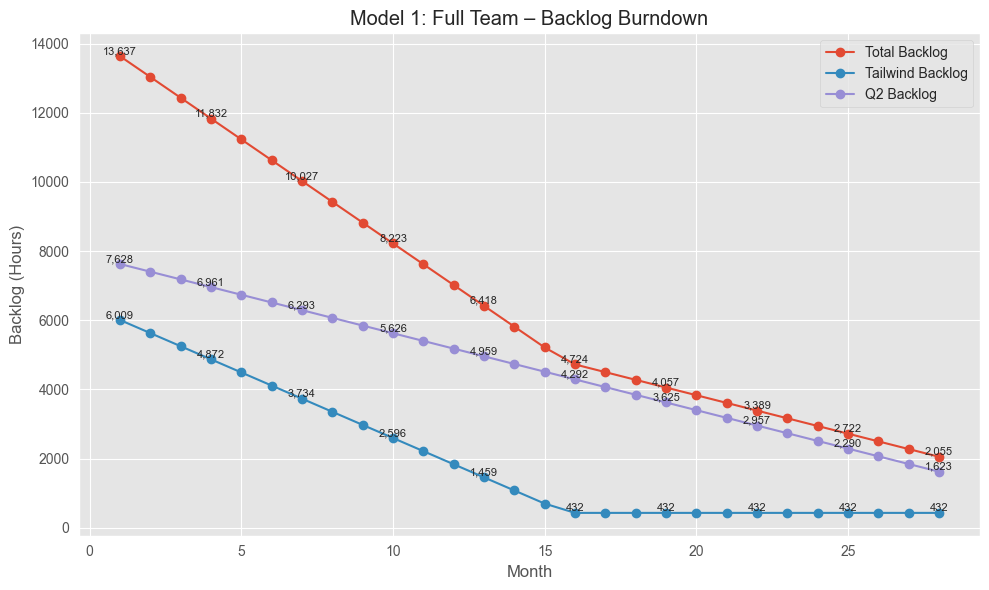

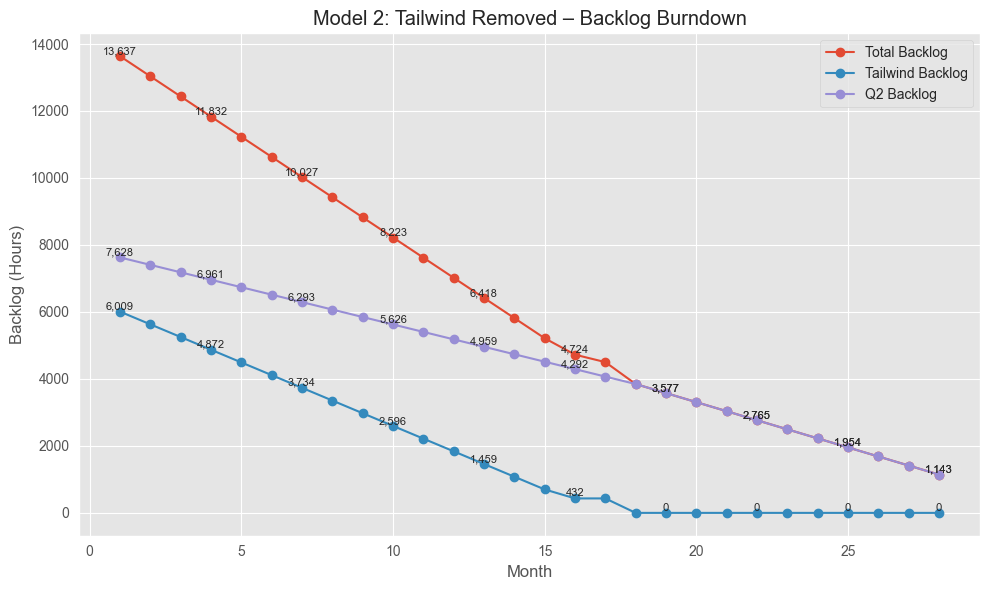

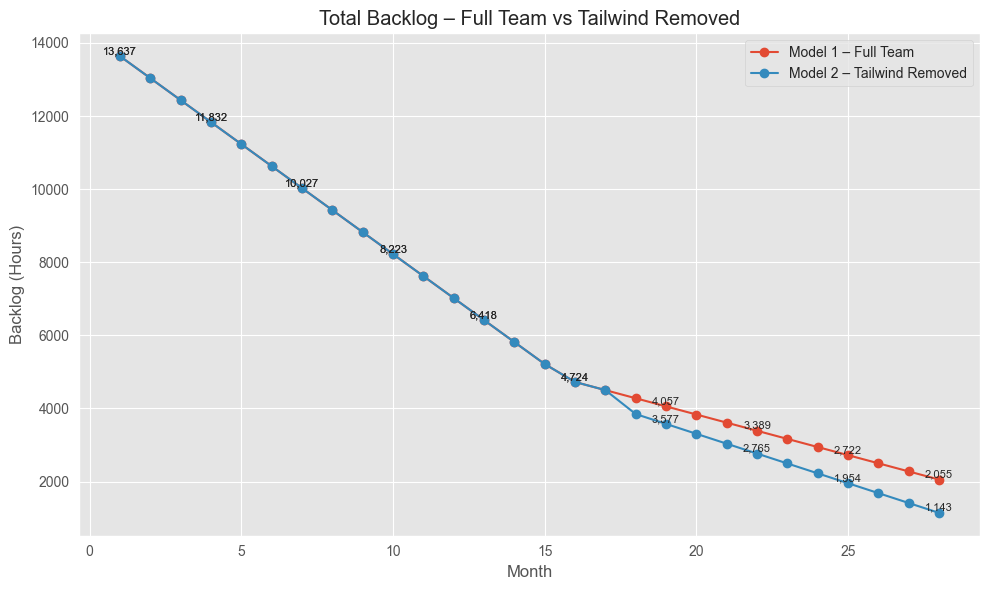

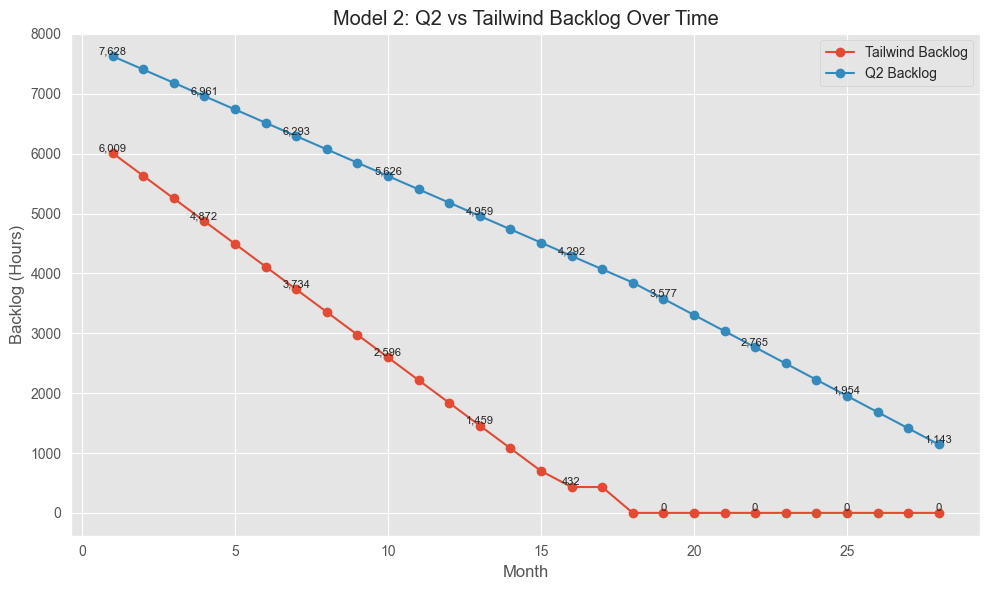

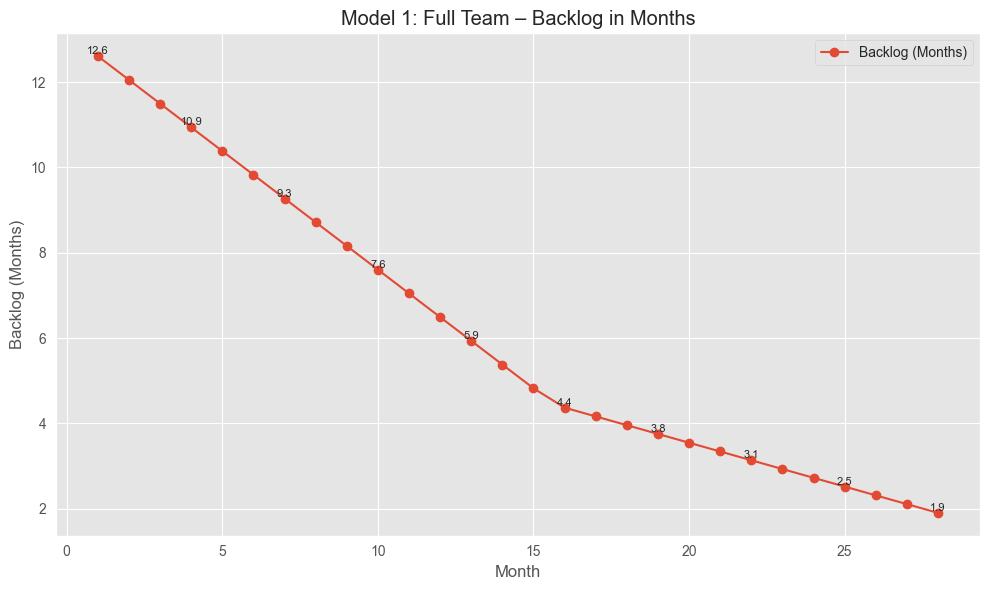

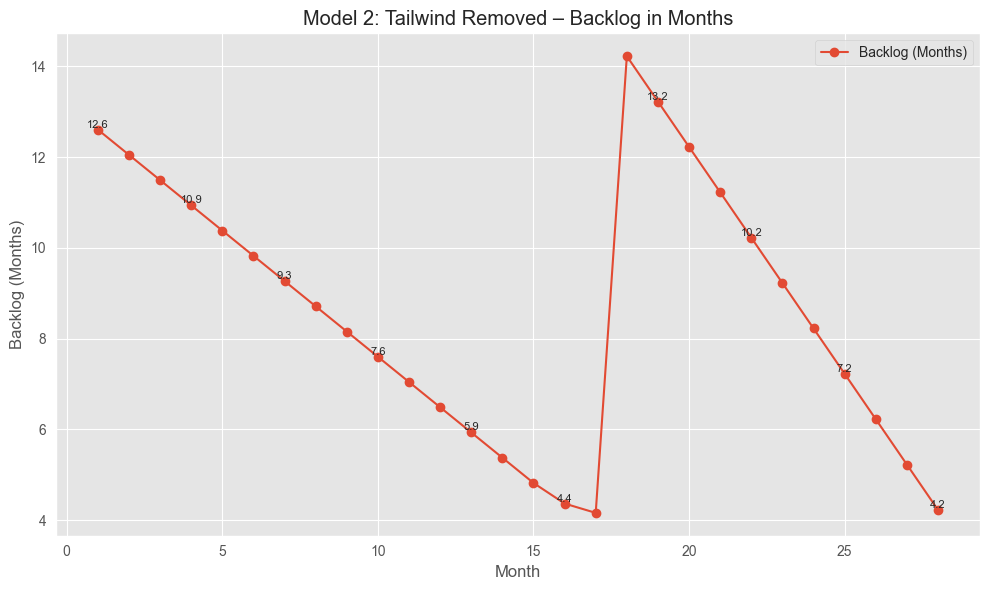

In [70]:
### ORIGINAL, NO WORK SHIFT

import pandas as pd

# Inputs from earlier calculations
TW_backlog = float(total_TW_backlog)
Q2_backlog = float(total_backlog - total_TW_backlog)

# Capacity assumptions
TW_capacity = 6 * 135.2   # 811.2
Q2_capacity = 2 * 135.2   # 270.4
total_capacity = TW_capacity + Q2_capacity

# Incoming work done as 1 quarter estimated effort, 90% to TW, 10% to Q2, split by month
TW_incoming = 1440 * 0.9 * (1/3)
Q2_incoming = 1440 * 0.1 * (1/3)

months = 28

results_full = []
results_reduced = []

# ---------------------------
# MODEL 1 – FULL TEAM 28 MONTHS
# ---------------------------
TW_b = TW_backlog
Q2_b = Q2_backlog

for month in range(1, months + 1):
    TW_burn = min(TW_b, TW_capacity)
    Q2_burn = min(Q2_b, Q2_capacity)

    # Update backlogs
    TW_b = max(TW_b - TW_burn + TW_incoming, 0)
    Q2_b = max(Q2_b - Q2_burn + Q2_incoming, 0)

    total_b = TW_b + Q2_b
    total_cap_current = TW_capacity + Q2_capacity  # constant in Model 1
    backlog_months = total_b / total_cap_current if total_cap_current > 0 else None

    results_full.append({
        "Month": month,
        "TW_Backlog": TW_b,
        "Q2_Backlog": Q2_b,
        "Total_Backlog": total_b,
        "Total_Capacity": total_cap_current,
        "Backlog_Months": backlog_months
    })

df_full = pd.DataFrame(results_full)

# ---------------------------
# MODEL 2 – REMOVE TAILWIND WHEN BACKLOG MONTHS <= 4
# ---------------------------
TW_b = TW_backlog
Q2_b = Q2_backlog

tailwind_active = True  # state flag

results_reduced = []

for month in range(1, months + 1):

    # Capacity & incoming for this month depend on whether Tailwind is still active
    if tailwind_active:
        TW_cap_current = TW_capacity
        TW_incoming_current = TW_incoming
        Q2_cap_current = Q2_capacity
        Q2_incoming_current = Q2_incoming
    else:
        TW_cap_current = 0
        TW_incoming_current = 0
        Q2_cap_current = Q2_capacity
        Q2_incoming_current = 0  # no new Q2 incoming once threshold hit

    # Burn
    TW_burn = min(TW_b, TW_cap_current)
    Q2_burn = min(Q2_b, Q2_cap_current)

    # Update backlogs
    TW_b = max(TW_b - TW_burn + TW_incoming_current, 0)
    Q2_b = max(Q2_b - Q2_burn + Q2_incoming_current, 0)

    # Compute metrics AFTER this month's work
    total_b = TW_b + Q2_b
    total_cap_current = TW_cap_current + Q2_cap_current
    backlog_months = total_b / total_cap_current if total_cap_current > 0 else None

    # Trigger removal when backlog-months threshold is reached
    if tailwind_active and (backlog_months is not None) and (backlog_months <= 4):
        tailwind_active = False
        # Hard clamp TW backlog to exactly 0 when threshold reached
        TW_b = 0.0
        # Recompute totals with Tailwind fully removed going forward
        total_b = TW_b + Q2_b
        total_cap_current = Q2_capacity
        backlog_months = total_b / total_cap_current if total_cap_current > 0 else None

    results_reduced.append({
        "Month": month,
        "TW_Backlog": TW_b,
        "Q2_Backlog": Q2_b,
        "Total_Backlog": total_b,
        "Total_Capacity": total_cap_current,
        "Backlog_Months": backlog_months,
        "Tailwind_Active": tailwind_active
    })

df_reduced = pd.DataFrame(results_reduced)

print("==== BURNDOWN MODEL – FULL TEAM ====")
print(df_full)

print("\n==== BURNDOWN MODEL – TAILWIND REMOVED WHEN BACKLOG MONTHS <= 4 ====")
print(df_reduced)
### ORIGNIAL CHARTS, NO SHIFTS

import matplotlib.pyplot as plt

# Global style tweaks for "prettier" charts
plt.style.use("ggplot")

def add_labels(x, y, step=3, fmt="{:,.0f}"):
    """
    Add data labels to every `step`-th point.
    """
    for i, (xx, yy) in enumerate(zip(x, y)):
        if i % step == 0:
            plt.text(xx, yy, fmt.format(yy), fontsize=8, ha='center', va='bottom')

# --------------------------------------
# 1) Backlog burndown – Model 1 (Full Team)
# --------------------------------------
plt.figure(figsize=(10, 6))
plt.plot(df_full["Month"], df_full["Total_Backlog"], marker='o', label="Total Backlog")
plt.plot(df_full["Month"], df_full["TW_Backlog"], marker='o', label="Tailwind Backlog")
plt.plot(df_full["Month"], df_full["Q2_Backlog"], marker='o', label="Q2 Backlog")

add_labels(df_full["Month"], df_full["Total_Backlog"], step=3)
add_labels(df_full["Month"], df_full["TW_Backlog"], step=3)
add_labels(df_full["Month"], df_full["Q2_Backlog"], step=3)

plt.xlabel("Month")
plt.ylabel("Backlog (Hours)")
plt.title("Model 1: Full Team – Backlog Burndown")
plt.legend()
plt.grid(True)
plt.tight_layout()

# --------------------------------------
# 2) Backlog burndown – Model 2 (Tailwind Removed at 4-Month Threshold)
# --------------------------------------
plt.figure(figsize=(10, 6))
plt.plot(df_reduced["Month"], df_reduced["Total_Backlog"], marker='o', label="Total Backlog")
plt.plot(df_reduced["Month"], df_reduced["TW_Backlog"], marker='o', label="Tailwind Backlog")
plt.plot(df_reduced["Month"], df_reduced["Q2_Backlog"], marker='o', label="Q2 Backlog")

add_labels(df_reduced["Month"], df_reduced["Total_Backlog"], step=3)
add_labels(df_reduced["Month"], df_reduced["TW_Backlog"], step=3)
add_labels(df_reduced["Month"], df_reduced["Q2_Backlog"], step=3)

plt.xlabel("Month")
plt.ylabel("Backlog (Hours)")
plt.title("Model 2: Tailwind Removed – Backlog Burndown")
plt.legend()
plt.grid(True)
plt.tight_layout()

# --------------------------------------
# 3) Side-by-side comparison of total backlog for both models
# --------------------------------------
plt.figure(figsize=(10, 6))
plt.plot(df_full["Month"], df_full["Total_Backlog"], marker='o', label="Model 1 – Full Team")
plt.plot(df_reduced["Month"], df_reduced["Total_Backlog"], marker='o', label="Model 2 – Tailwind Removed")

add_labels(df_full["Month"], df_full["Total_Backlog"], step=3)
add_labels(df_reduced["Month"], df_reduced["Total_Backlog"], step=3)

plt.xlabel("Month")
plt.ylabel("Backlog (Hours)")
plt.title("Total Backlog – Full Team vs Tailwind Removed")
plt.legend()
plt.grid(True)
plt.tight_layout()

# --------------------------------------
# 4) Breakdown – Q2 vs Tailwind (Model 2, Hours)
# --------------------------------------
plt.figure(figsize=(10, 6))
plt.plot(df_reduced["Month"], df_reduced["TW_Backlog"], marker='o', label="Tailwind Backlog")
plt.plot(df_reduced["Month"], df_reduced["Q2_Backlog"], marker='o', label="Q2 Backlog")

add_labels(df_reduced["Month"], df_reduced["TW_Backlog"], step=3)
add_labels(df_reduced["Month"], df_reduced["Q2_Backlog"], step=3)

plt.xlabel("Month")
plt.ylabel("Backlog (Hours)")
plt.title("Model 2: Q2 vs Tailwind Backlog Over Time")
plt.legend()
plt.grid(True)
plt.tight_layout()

# --------------------------------------
# 5) Backlog Months – Model 1
# --------------------------------------
plt.figure(figsize=(10, 6))
plt.plot(df_full["Month"], df_full["Backlog_Months"], marker='o', label="Backlog (Months)")

add_labels(df_full["Month"], df_full["Backlog_Months"], step=3, fmt="{:.1f}")

plt.xlabel("Month")
plt.ylabel("Backlog (Months)")
plt.title("Model 1: Full Team – Backlog in Months")
plt.legend()
plt.grid(True)
plt.tight_layout()

# --------------------------------------
# 6) Backlog Months – Model 2
# --------------------------------------
plt.figure(figsize=(10, 6))
plt.plot(df_reduced["Month"], df_reduced["Backlog_Months"], marker='o', label="Backlog (Months)")

add_labels(df_reduced["Month"], df_reduced["Backlog_Months"], step=3, fmt="{:.1f}")

plt.xlabel("Month")
plt.ylabel("Backlog (Months)")
plt.title("Model 2: Tailwind Removed – Backlog in Months")
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.show()
